## Deep Neural Network with Long Short-Term Memory Layer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import contextily as ctx
from pyproj import Transformer
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Conv2D, Flatten, Reshape, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from keras.layers import Bidirectional

In [4]:
import data_processing
import feature_extraction

In [5]:
df = data_processing.read_all_users('geolife_trajectories')
df = data_processing.process_classes(df)
df = data_processing.drop_unlabelled(df)

[1/182] processing user 135
[2/182] processing user 132
[3/182] processing user 104
[4/182] processing user 103
[5/182] processing user 168
[6/182] processing user 157
[7/182] processing user 150
[8/182] processing user 159
[9/182] processing user 166
[10/182] processing user 161
[11/182] processing user 102
[12/182] processing user 105
[13/182] processing user 133
[14/182] processing user 134
[15/182] processing user 160
[16/182] processing user 158
[17/182] processing user 167
[18/182] processing user 151
[19/182] processing user 169
[20/182] processing user 156
[21/182] processing user 024
[22/182] processing user 023
[23/182] processing user 015
[24/182] processing user 012
[25/182] processing user 079
[26/182] processing user 046
[27/182] processing user 041
[28/182] processing user 048
[29/182] processing user 077
[30/182] processing user 083
[31/182] processing user 084
[32/182] processing user 070
[33/182] processing user 013
[34/182] processing user 014
[35/182] processing use

In [6]:
df = data_processing.create_segments(df)
df = data_processing.calculations(df)
df = data_processing.filter(df)

In [5]:
updated_df = pd.read_pickle("updated_df_fifteen.pkl")

In [6]:
time_series_features = ['speed', 'acceleration','jerk','heading_change','angular_velocity', 'angular_acceleration']

Normalize both datasets the same way

In [7]:
columns = ['speed', 'acceleration','jerk','heading_change','angular_velocity', 'angular_acceleration']

global_mins = {}
global_maxs = {}

for col in columns:
    # Get min/max from both datasets
    min1 = df[col].min()
    max1 = df[col].max()
    min2 = updated_df[col].min()
    max2 = updated_df[col].max()
    
    # Compute global values
    global_mins[col] = min(min1, min2)
    global_maxs[col] = max(max1, max2)

print("Global Minimums:", global_mins)
print("Global Maximums:", global_maxs)

Global Minimums: {'speed': 0.00022085781252921755, 'acceleration': -1878.88247646102, 'jerk': -2846.625663814707, 'heading_change': 0.0, 'angular_velocity': 0.0, 'angular_acceleration': -180.0}
Global Maximums: {'speed': 293.3060715168033, 'acceleration': 246.93771635310583, 'jerk': 765922.0469761436, 'heading_change': 180.0, 'angular_velocity': 180.0, 'angular_acceleration': 180.0}


In [ ]:
def normalize_features(df, global_mins, global_maxs):
    """
    Normalize features using global min/max
    """
    normalized_df = df.copy()
    for feature in ['speed', 'acceleration','jerk','heading_change','angular_velocity', 'angular_acceleration']:  
        min_val = global_mins[feature]
        max_val = global_maxs[feature]
        
        # Avoid division by zero (use epsilon if max == min)
        denominator = max_val - min_val
        if denominator == 0:
            denominator = 1  # Or use a small epsilon (e.g., 1e-8)
        
        normalized_df[feature] = (df[feature] - min_val) / denominator
    
    return normalized_df

# Normalize both datasets
df = normalize_features(df, global_mins, global_maxs)
updated_df = normalize_features(updated_df, global_mins, global_maxs)

print("Normalized Dataset 1:")
print(df)
print("\nNormalized Dataset 2:")
print(updated_df)

Normalized Dataset 1:
               lat         lon         alt  elapsed time                time  \
0        39.976200  116.330383  229.658793  39184.432917 2007-04-12 10:23:24   
1        39.976033  116.330367  259.186352  39184.434132 2007-04-12 10:25:09   
2        39.975817  116.330300  275.590551  39184.434398 2007-04-12 10:25:32   
3        39.975700  116.330333  295.275591  39184.435613 2007-04-12 10:27:17   
4        39.975383  116.330667  137.795276  39184.611030 2007-04-12 14:39:53   
...            ...         ...         ...           ...                 ...   
4166298  39.991613  116.330468    0.000000  40908.637292 2011-12-31 15:17:42   
4166299  39.991615  116.330483    0.000000  40908.637350 2011-12-31 15:17:47   
4166300  39.991630  116.330473    0.000000  40908.637407 2011-12-31 15:17:52   
4166301  39.991642  116.330465    0.000000  40908.637465 2011-12-31 15:17:57   
4166302  39.991670  116.330468    0.000000  40908.637523 2011-12-31 15:18:02   

                 

In [9]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [10]:
X_sequences = []
y_sequences = []

for _, group in df.groupby('segment'):
    X_sequences.append(group[time_series_features].values)  # Raw sequences
    y_sequences.append(group['label'].iloc[0])  # Assign one label per segment

In [11]:
for i, seq in enumerate(X_sequences):
    print(f"Shape of sequence {i}: {seq.shape}")

Shape of sequence 0: (4, 6)
Shape of sequence 1: (44, 6)
Shape of sequence 2: (22, 6)
Shape of sequence 3: (38, 6)
Shape of sequence 4: (28, 6)
Shape of sequence 5: (44, 6)
Shape of sequence 6: (21, 6)
Shape of sequence 7: (4, 6)
Shape of sequence 8: (23, 6)
Shape of sequence 9: (23, 6)
Shape of sequence 10: (14, 6)
Shape of sequence 11: (2, 6)
Shape of sequence 12: (81, 6)
Shape of sequence 13: (73, 6)
Shape of sequence 14: (112, 6)
Shape of sequence 15: (20, 6)
Shape of sequence 16: (68, 6)
Shape of sequence 17: (8, 6)
Shape of sequence 18: (31, 6)
Shape of sequence 19: (8, 6)
Shape of sequence 20: (27, 6)
Shape of sequence 21: (348, 6)
Shape of sequence 22: (229, 6)
Shape of sequence 23: (30, 6)
Shape of sequence 24: (13, 6)
Shape of sequence 25: (160, 6)
Shape of sequence 26: (125, 6)
Shape of sequence 27: (304, 6)
Shape of sequence 28: (48, 6)
Shape of sequence 29: (40, 6)
Shape of sequence 30: (93, 6)
Shape of sequence 31: (96, 6)
Shape of sequence 32: (415, 6)
Shape of sequence 

In [ ]:
unique_labels, counts = np.unique(y_sequences, return_counts=True)

print("Counts of each label in y_sequences:")
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count}")

Counts of each label in y_sequences:
Label 0: 1899
Label 1: 2633
Label 2: 2110
Label 3: 1247
Label 4: 6012


In [13]:
# Convert labels to one-hot encoding
y_sequences = to_categorical(y_sequences)
y_sequences

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=19)

In [15]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=19)

In [ ]:
def create_rolling_windows(X_sequences, y_sequences, window_size=200, step=100):
    """
    Creates rolling window segments from time-series data, padding short sequences at the beginning.
    
    - X_sequences: List of time-series feature sequences (NumPy arrays)
    - y_sequences: List of corresponding labels.
    - window_size: Number of time steps per window
    - step: Step size between windows
    
    Returns:
    - X_windows: NumPy array of rolling window samples
    - y_windows: NumPy array of labels
    """
    X_windows = []
    y_windows = []

    for i in range(len(X_sequences)):  # Loop through sequences
        seq = X_sequences[i]  # Extract single trajectory
        label = y_sequences[i]  # Corresponding label

        # If sequence is shorter than window_size, pad at the beginning
        if len(seq) < window_size:
            pad_length = window_size - len(seq)
            pad = np.zeros((pad_length, seq.shape[1]))  # Create zero padding
            seq = np.vstack((seq, pad))  # Stack padding **after** existing data

            # Add the single padded sequence
            X_windows.append(seq)
            y_windows.append(label)
            continue  # Skip rolling window logic for this sequence

        # Create rolling windows within the sequence
        for j in range(0, len(seq) - window_size + 1, step):
            X_windows.append(seq[j:j + window_size])  # Extract window
            y_windows.append(label)  # Use the same label for entire window

    return np.array(X_windows), np.array(y_windows)

In [17]:
window_size = 200
step_size = 100

In [18]:
# Create rolling windows
X_train2, y_train2 = create_rolling_windows(X_train2, y_train2, window_size, step_size)

# Verify shape
print("Shape of X_train:", X_train2.shape)
print("Shape of y_train:", y_train2.shape)

Shape of X_train: (25094, 200, 6)
Shape of y_train: (25094, 5)


In [19]:
X_test, y_test = create_rolling_windows(X_test, y_test, window_size, step_size)

# Verify shape
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_test: (7504, 200, 6)
Shape of y_test: (7504, 5)


In [20]:
# Create rolling windows
X_val, y_val = create_rolling_windows(X_val, y_val, window_size, step_size)

# Verify shape
print("Shape of X_val", X_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_val (2669, 200, 6)
Shape of y_val: (2669, 5)


In [21]:
def create_lstm_model(input_shape, num_classes):
    model = Sequential()
    
    # Use Conv1D for time-series feature extraction
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    
    # LSTM Layers
    model.add(LSTM(128, return_sequences=True))  # Retain temporal dimension
    model.add(Dropout(0.3))
    
    model.add(LSTM(64))  # Final LSTM layer returns output (no sequence)
    model.add(Dropout(0.3))
    
    # Dense Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [22]:
input_shape = (X_train2.shape[1], X_train2.shape[2])  # (time_steps, features)
num_classes = y_train.shape[1]
model = create_lstm_model(input_shape, num_classes)

model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 198, 32)        │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 198, 128)       │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 198, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,853 (542.39 KB)

 Trainable params: 138,853 (542.39 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Reduce learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model to best state
)

# Train the model
history = model.fit(X_train2, y_train2, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 126s 159ms/step - accuracy: 0.4090 - loss: 1.3957 - val_accuracy: 0.4050 - val_loss: 1.2480 - learning_rate: 0.0010
Epoch 2/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 127s 162ms/step - accuracy: 0.4325 - loss: 1.2721 - val_accuracy: 0.2379 - val_loss: 1.5708 - learning_rate: 0.0010
Epoch 3/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 127s 162ms/step - accuracy: 0.3394 - loss: 1.4843 - val_accuracy: 0.6538 - val_loss: 0.8898 - learning_rate: 0.0010
Epoch 4/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 121s 154ms/step - accuracy: 0.6401 - loss: 0.9710 - val_accuracy: 0.7036 - val_loss: 0.8395 - learning_rate: 0.0010
Epoch 5/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 138s 176ms/step - accuracy: 0.6892 - loss: 0.8753 - val_accuracy: 0.7617 - val_loss: 0.6791 - learning_rate: 0.0010
Epoch 6/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 137s 175ms/step - accuracy: 0.7288 - loss: 0.7786 - val_accuracy: 0.7834 - val_loss: 0.6656 - learning_rate: 0.0010
Epoch 7/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 132s 169ms/step - accura

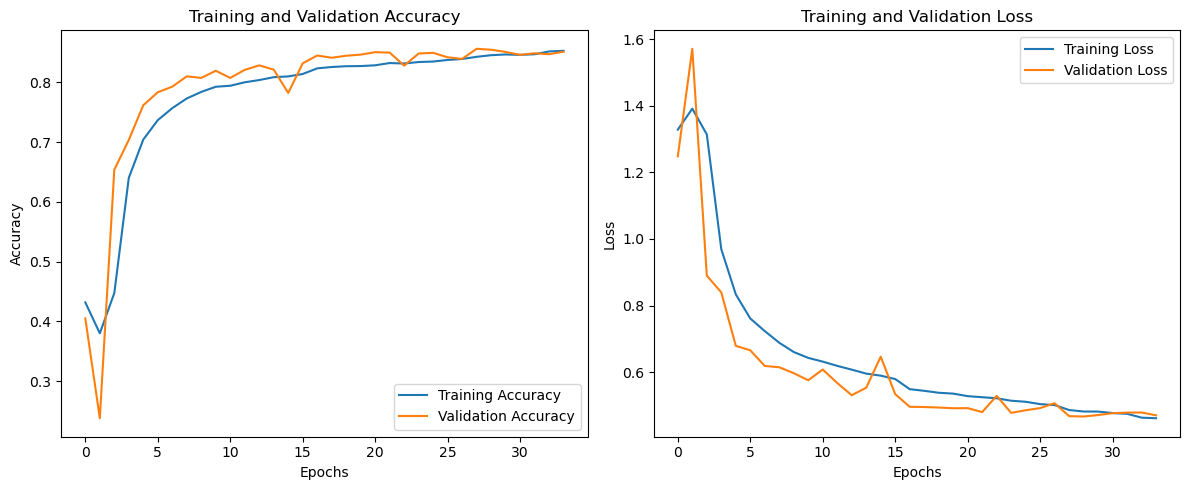

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step
Classification Report:
               precision    recall  f1-score   support

        bike      0.921     0.862     0.890      1022
         bus      0.861     0.762     0.809      1818
         car      0.706     0.735     0.720      1026
       train      0.964     0.909     0.935      1838
        walk      0.837     0.993     0.909      1800

    accuracy                          0.863      7504
   macro avg      0.858     0.852     0.853      7504
weighted avg      0.867     0.863     0.863      7504



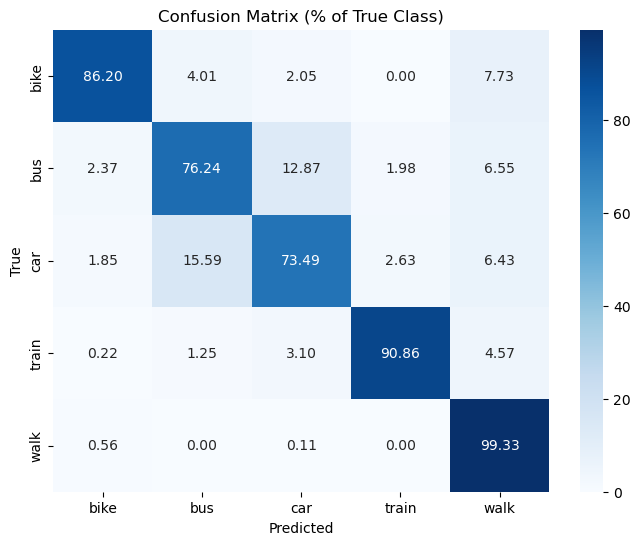

In [24]:
# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report with TRUE LABELS
print("Classification Report:\n", 
      classification_report(
          y_true_classes, 
          y_pred_classes, 
          target_names=label_encoder.classes_,digits=3  # Add class names here
      ))

# Confusion Matrix in percentages
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_percent, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=label_encoder.classes_,  # True labels for axes
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (% of True Class)")
plt.show()

Bi-Conv-LSTM

In [25]:
def create_bilstm_model(input_shape, num_classes):
    model = Sequential()
    
    # Conv1D remains the same for initial feature extraction
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    
    # First LSTM converted to Bidirectional
    model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Now processes both directions
    model.add(Dropout(0.3))  # Same dropout rate
    
    # Second LSTM converted to Bidirectional (no return_sequences)
    model.add(Bidirectional(LSTM(64)))  # Now processes both directions
    model.add(Dropout(0.3))
    
    # Dense layers remain unchanged
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compilation remains the same
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [26]:
input_shape = (X_train2.shape[1], X_train2.shape[2])  # (time_steps, features)
num_classes = y_train.shape[1]
modelbi = create_bilstm_model(input_shape, num_classes)

modelbi.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 198, 32)        │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 198, 256)       │       164,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 198, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 340,325 (1.30 MB)

 Trainable params: 340,325 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Reduce learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model to best state
)

# Train the model
history = modelbi.fit(X_train2, y_train2, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 284s 358ms/step - accuracy: 0.4828 - loss: 1.2494 - val_accuracy: 0.6081 - val_loss: 0.9771 - learning_rate: 0.0010
Epoch 2/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 297s 379ms/step - accuracy: 0.6082 - loss: 1.0225 - val_accuracy: 0.7190 - val_loss: 0.7759 - learning_rate: 0.0010
Epoch 3/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 281s 358ms/step - accuracy: 0.6844 - loss: 0.8671 - val_accuracy: 0.7205 - val_loss: 0.7595 - learning_rate: 0.0010
Epoch 4/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 277s 353ms/step - accuracy: 0.7359 - loss: 0.7704 - val_accuracy: 0.7688 - val_loss: 0.6546 - learning_rate: 0.0010
Epoch 5/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 273s 347ms/step - accuracy: 0.7013 - loss: 0.8247 - val_accuracy: 0.7658 - val_loss: 0.6952 - learning_rate: 0.0010
Epoch 6/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 277s 353ms/step - accuracy: 0.7450 - loss: 0.7238 - val_accuracy: 0.7894 - val_loss: 0.6251 - learning_rate: 0.0010
Epoch 7/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 280s 356ms/step - accura

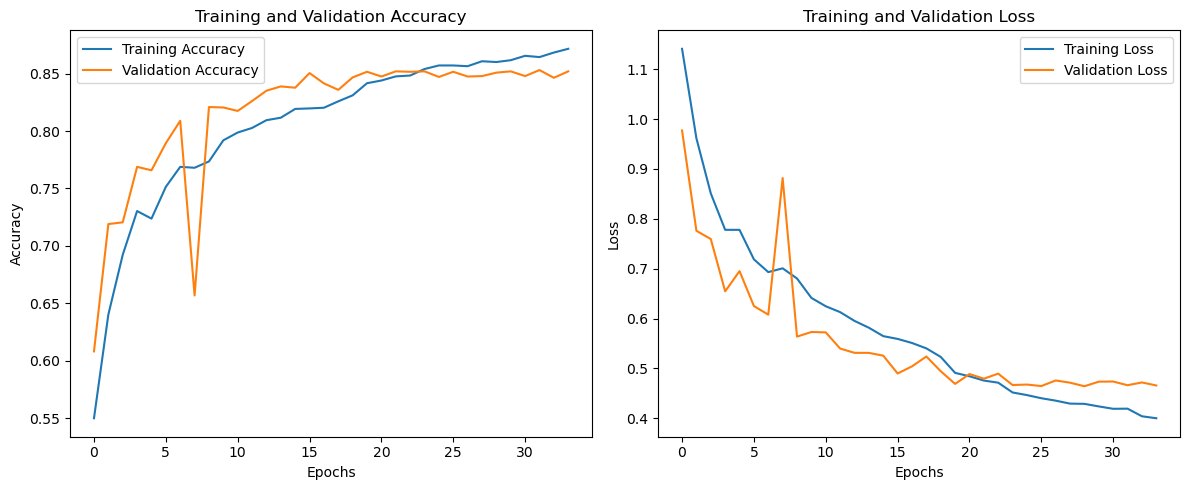

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step
Classification Report:
               precision    recall  f1-score   support

        bike      0.917     0.871     0.893      1022
         bus      0.867     0.750     0.804      1818
         car      0.696     0.765     0.729      1026
       train      0.970     0.910     0.939      1838
        walk      0.847     0.992     0.914      1800

    accuracy                          0.866      7504
   macro avg      0.859     0.858     0.856      7504
weighted avg      0.871     0.866     0.865      7504



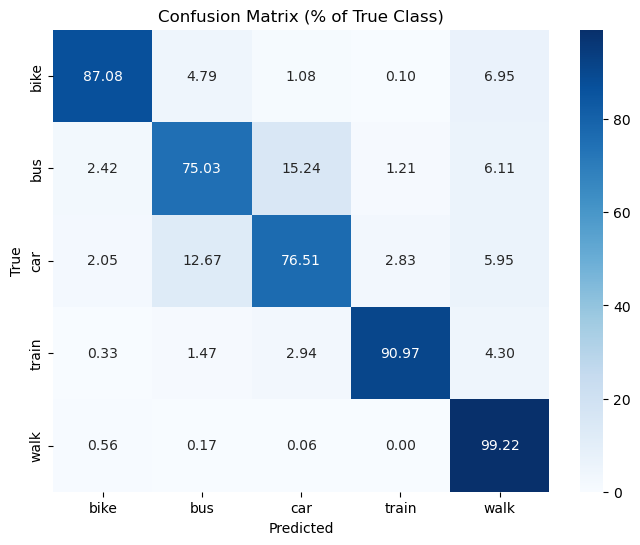

In [28]:
# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# Make predictions
y_pred = modelbi.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report with TRUE LABELS
print("Classification Report:\n", 
      classification_report(
          y_true_classes, 
          y_pred_classes, 
          target_names=label_encoder.classes_ ,digits=3 # Add class names here
      ))

# Confusion Matrix in percentages
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_percent, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=label_encoder.classes_,  # True labels for axes
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (% of True Class)")
plt.show()

Other features

In [29]:
time_series_features = ['speed', 'acceleration','jerk']

In [30]:
X_sequences = []
y_sequences = []

for _, group in df.groupby('segment'):
    X_sequences.append(group[time_series_features].values)  # Raw sequences
    y_sequences.append(group['label'].iloc[0])  # Assign one label per segment

In [31]:
for i, seq in enumerate(X_sequences):
    print(f"Shape of sequence {i}: {seq.shape}")

Shape of sequence 0: (4, 3)
Shape of sequence 1: (44, 3)
Shape of sequence 2: (22, 3)
Shape of sequence 3: (38, 3)
Shape of sequence 4: (28, 3)
Shape of sequence 5: (44, 3)
Shape of sequence 6: (21, 3)
Shape of sequence 7: (4, 3)
Shape of sequence 8: (23, 3)
Shape of sequence 9: (23, 3)
Shape of sequence 10: (14, 3)
Shape of sequence 11: (2, 3)
Shape of sequence 12: (81, 3)
Shape of sequence 13: (73, 3)
Shape of sequence 14: (112, 3)
Shape of sequence 15: (20, 3)
Shape of sequence 16: (68, 3)
Shape of sequence 17: (8, 3)
Shape of sequence 18: (31, 3)
Shape of sequence 19: (8, 3)
Shape of sequence 20: (27, 3)
Shape of sequence 21: (348, 3)
Shape of sequence 22: (229, 3)
Shape of sequence 23: (30, 3)
Shape of sequence 24: (13, 3)
Shape of sequence 25: (160, 3)
Shape of sequence 26: (125, 3)
Shape of sequence 27: (304, 3)
Shape of sequence 28: (48, 3)
Shape of sequence 29: (40, 3)
Shape of sequence 30: (93, 3)
Shape of sequence 31: (96, 3)
Shape of sequence 32: (415, 3)
Shape of sequence 

In [32]:
# Convert labels to one-hot encoding
y_sequences = to_categorical(y_sequences)
y_sequences

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=19)

In [34]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=19)

In [36]:
# Create rolling windows
X_train2, y_train2 = create_rolling_windows(X_train2, y_train2, window_size, step_size)

# Verify shape
print("Shape of X_train:", X_train2.shape)
print("Shape of y_train:", y_train2.shape)

Shape of X_train: (25094, 200, 3)
Shape of y_train: (25094, 5)


In [37]:
X_test, y_test = create_rolling_windows(X_test, y_test, window_size, step_size)

# Verify shape
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_test: (7504, 200, 3)
Shape of y_test: (7504, 5)


In [38]:
# Create rolling windows
X_val, y_val = create_rolling_windows(X_val, y_val, window_size, step_size)

# Verify shape
print("Shape of X_val", X_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_val (2669, 200, 3)
Shape of y_val: (2669, 5)


In [39]:
def create_lstm_model(input_shape, num_classes):
    model = Sequential()
    
    # Use Conv1D for time-series feature extraction
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    
    # LSTM Layers
    model.add(LSTM(128, return_sequences=True))  # Retain temporal dimension
    model.add(Dropout(0.3))
    
    model.add(LSTM(64))  # Final LSTM layer returns output (no sequence)
    model.add(Dropout(0.3))
    
    # Dense Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [40]:
input_shape = (X_train2.shape[1], X_train2.shape[2])  # (time_steps, features)
num_classes = y_train.shape[1]
model2 = create_lstm_model(input_shape, num_classes)

model2.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 198, 32)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 198, 128)       │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 198, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,565 (541.27 KB)

 Trainable params: 138,565 (541.27 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Reduce learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model to best state
)

# Train the model
history = model2.fit(X_train2, y_train2, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 121s 152ms/step - accuracy: 0.3408 - loss: 1.4967 - val_accuracy: 0.5126 - val_loss: 1.1846 - learning_rate: 0.0010
Epoch 2/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 118s 150ms/step - accuracy: 0.5069 - loss: 1.2155 - val_accuracy: 0.2342 - val_loss: 3.3009 - learning_rate: 0.0010
Epoch 3/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 122s 155ms/step - accuracy: 0.5395 - loss: 1.1557 - val_accuracy: 0.7209 - val_loss: 0.8115 - learning_rate: 0.0010
Epoch 4/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 120s 153ms/step - accuracy: 0.5927 - loss: 1.0437 - val_accuracy: 0.6021 - val_loss: 1.0521 - learning_rate: 0.0010
Epoch 5/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 119s 152ms/step - accuracy: 0.5568 - loss: 1.0877 - val_accuracy: 0.6605 - val_loss: 0.8966 - learning_rate: 0.0010
Epoch 6/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 123s 157ms/step - accuracy: 0.6671 - loss: 0.8995 - val_accuracy: 0.6418 - val_loss: 0.9746 - learning_rate: 0.0010
Epoch 7/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 112s 142ms/step - accura

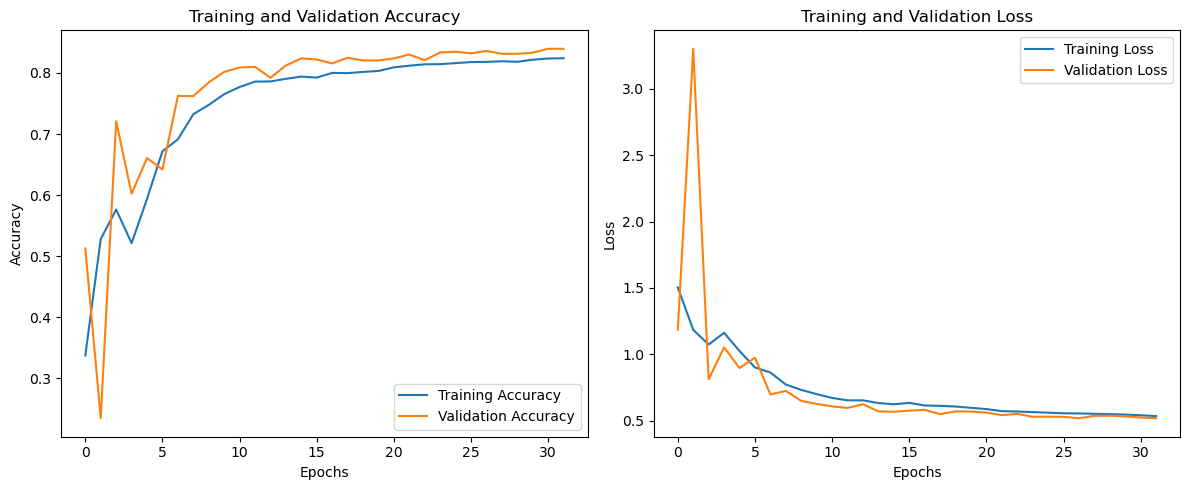

235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step
Classification Report:
               precision    recall  f1-score   support

        bike      0.907     0.861     0.884      1022
         bus      0.837     0.734     0.782      1818
         car      0.657     0.680     0.668      1026
       train      0.949     0.909     0.928      1838
        walk      0.834     0.981     0.901      1800

    accuracy                          0.846      7504
   macro avg      0.837     0.833     0.833      7504
weighted avg      0.849     0.846     0.845      7504



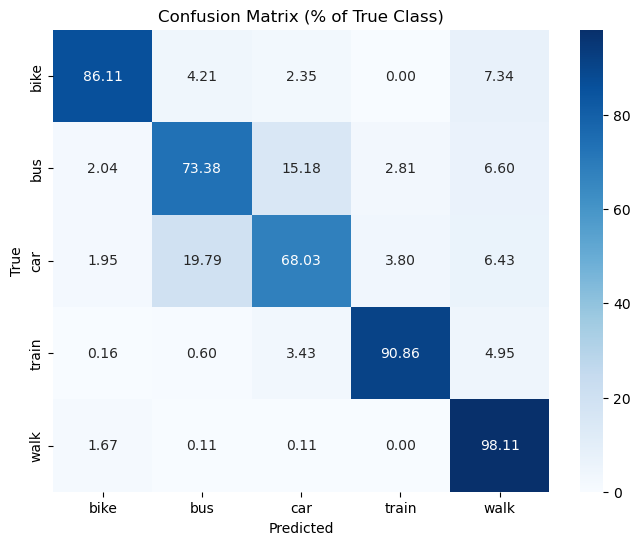

In [42]:
# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# Make predictions
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report with TRUE LABELS
print("Classification Report:\n", 
      classification_report(
          y_true_classes, 
          y_pred_classes, 
          target_names=label_encoder.classes_ ,digits=3 # Add class names here
      ))

# Confusion Matrix in percentages
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_percent, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=label_encoder.classes_,  # True labels for axes
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (% of True Class)")
plt.show()

Bi-LSTM

In [43]:
def create_bilstm_model(input_shape, num_classes):
    model = Sequential()
    
    # Conv1D remains the same for initial feature extraction
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    
    # First LSTM converted to Bidirectional
    model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Now processes both directions
    model.add(Dropout(0.3))  # Same dropout rate
    
    # Second LSTM converted to Bidirectional (no return_sequences)
    model.add(Bidirectional(LSTM(64)))  # Now processes both directions
    model.add(Dropout(0.3))
    
    # Dense layers remain unchanged
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compilation remains the same
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [44]:
input_shape = (X_train2.shape[1], X_train2.shape[2])  # (time_steps, features)
num_classes = y_train.shape[1]
model2bi = create_bilstm_model(input_shape, num_classes)

model2bi.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 198, 32)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 198, 256)       │       164,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 198, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 340,037 (1.30 MB)

 Trainable params: 340,037 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Reduce learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model to best state
)

# Train the model
history = model2bi.fit(X_train2, y_train2, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 244s 308ms/step - accuracy: 0.4709 - loss: 1.2675 - val_accuracy: 0.3687 - val_loss: 1.4747 - learning_rate: 0.0010
Epoch 2/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 267s 340ms/step - accuracy: 0.5721 - loss: 1.0863 - val_accuracy: 0.6733 - val_loss: 0.8744 - learning_rate: 0.0010
Epoch 3/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 265s 337ms/step - accuracy: 0.6172 - loss: 1.0000 - val_accuracy: 0.7179 - val_loss: 0.7905 - learning_rate: 0.0010
Epoch 4/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 265s 337ms/step - accuracy: 0.6989 - loss: 0.8412 - val_accuracy: 0.6782 - val_loss: 0.8576 - learning_rate: 0.0010
Epoch 5/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 266s 338ms/step - accuracy: 0.6972 - loss: 0.8454 - val_accuracy: 0.7737 - val_loss: 0.6919 - learning_rate: 0.0010
Epoch 6/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 264s 336ms/step - accuracy: 0.7351 - loss: 0.7680 - val_accuracy: 0.6242 - val_loss: 0.9871 - learning_rate: 0.0010
Epoch 7/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 272s 346ms/step - accura

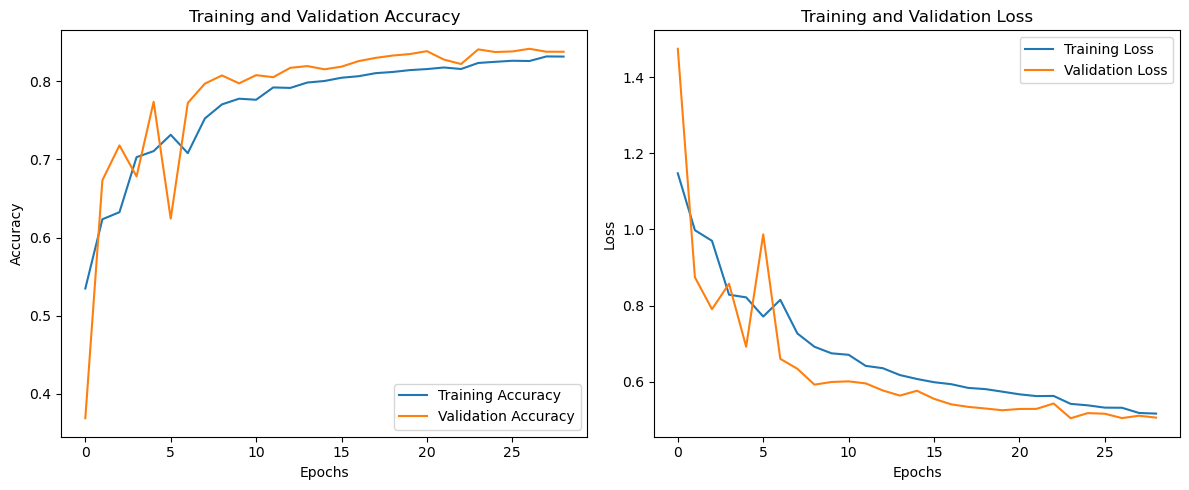

235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step
Classification Report:
               precision    recall  f1-score   support

        bike      0.929     0.844     0.885      1022
         bus      0.838     0.734     0.782      1818
         car      0.678     0.724     0.700      1026
       train      0.949     0.913     0.930      1838
        walk      0.835     0.982     0.903      1800

    accuracy                          0.851      7504
   macro avg      0.846     0.840     0.840      7504
weighted avg      0.855     0.851     0.850      7504



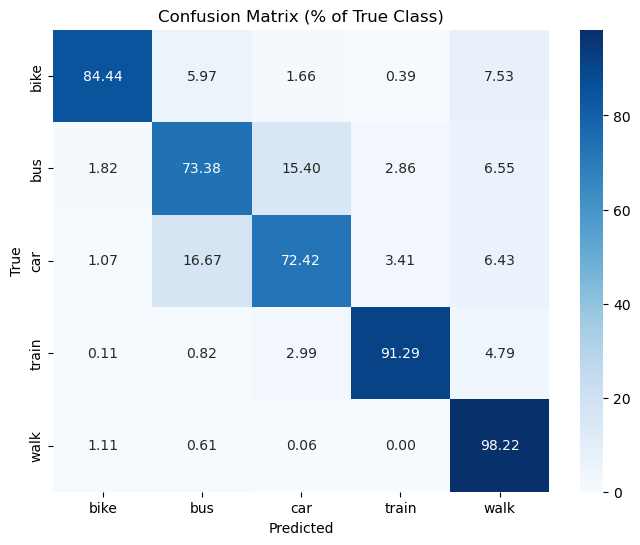

In [46]:
# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# Make predictions
y_pred = model2bi.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report with TRUE LABELS
print("Classification Report:\n", 
      classification_report(
          y_true_classes, 
          y_pred_classes, 
          target_names=label_encoder.classes_ ,digits=3 # Add class names here
      ))

# Confusion Matrix in percentages
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_percent, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=label_encoder.classes_,  # True labels for axes
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (% of True Class)")
plt.show()

In [47]:
time_series_features = ['speed', 'acceleration','jerk','angular_acceleration']

In [48]:
X_sequences = []
y_sequences = []

for _, group in df.groupby('segment'):
    X_sequences.append(group[time_series_features].values)  # Raw sequences
    y_sequences.append(group['label'].iloc[0])  # Assign one label per segment

In [49]:
for i, seq in enumerate(X_sequences):
    print(f"Shape of sequence {i}: {seq.shape}")

Shape of sequence 0: (4, 4)
Shape of sequence 1: (44, 4)
Shape of sequence 2: (22, 4)
Shape of sequence 3: (38, 4)
Shape of sequence 4: (28, 4)
Shape of sequence 5: (44, 4)
Shape of sequence 6: (21, 4)
Shape of sequence 7: (4, 4)
Shape of sequence 8: (23, 4)
Shape of sequence 9: (23, 4)
Shape of sequence 10: (14, 4)
Shape of sequence 11: (2, 4)
Shape of sequence 12: (81, 4)
Shape of sequence 13: (73, 4)
Shape of sequence 14: (112, 4)
Shape of sequence 15: (20, 4)
Shape of sequence 16: (68, 4)
Shape of sequence 17: (8, 4)
Shape of sequence 18: (31, 4)
Shape of sequence 19: (8, 4)
Shape of sequence 20: (27, 4)
Shape of sequence 21: (348, 4)
Shape of sequence 22: (229, 4)
Shape of sequence 23: (30, 4)
Shape of sequence 24: (13, 4)
Shape of sequence 25: (160, 4)
Shape of sequence 26: (125, 4)
Shape of sequence 27: (304, 4)
Shape of sequence 28: (48, 4)
Shape of sequence 29: (40, 4)
Shape of sequence 30: (93, 4)
Shape of sequence 31: (96, 4)
Shape of sequence 32: (415, 4)
Shape of sequence 

In [50]:
# Convert labels to one-hot encoding
y_sequences = to_categorical(y_sequences)
y_sequences

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=19)

In [52]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=19)

In [54]:
# Create rolling windows
X_train2, y_train2 = create_rolling_windows(X_train2, y_train2, window_size, step_size)

# Verify shape
print("Shape of X_train:", X_train2.shape)
print("Shape of y_train:", y_train2.shape)

Shape of X_train: (25094, 200, 4)
Shape of y_train: (25094, 5)


In [55]:
X_test, y_test = create_rolling_windows(X_test, y_test, window_size, step_size)

# Verify shape
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_test: (7504, 200, 4)
Shape of y_test: (7504, 5)


In [56]:
# Create rolling windows
X_val, y_val = create_rolling_windows(X_val, y_val, window_size, step_size)

# Verify shape
print("Shape of X_val", X_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_val (2669, 200, 4)
Shape of y_val: (2669, 5)


In [57]:
def create_lstm_model(input_shape, num_classes):
    model = Sequential()
    
    # Use Conv1D for time-series feature extraction
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    
    # LSTM Layers
    model.add(LSTM(128, return_sequences=True))  # Retain temporal dimension
    model.add(Dropout(0.3))
    
    model.add(LSTM(64))  # Final LSTM layer returns output (no sequence)
    model.add(Dropout(0.3))
    
    # Dense Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [58]:
input_shape = (X_train2.shape[1], X_train2.shape[2])  # (time_steps, features)
num_classes = y_train.shape[1]
model3 = create_lstm_model(input_shape, num_classes)

model3.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 198, 32)        │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 198, 128)       │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 198, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,661 (541.64 KB)

 Trainable params: 138,661 (541.64 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Reduce learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model to best state
)

# Train the model
history = model3.fit(X_train2, y_train2, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 111s 139ms/step - accuracy: 0.3955 - loss: 1.4027 - val_accuracy: 0.3099 - val_loss: 1.5716 - learning_rate: 0.0010
Epoch 2/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 110s 140ms/step - accuracy: 0.2851 - loss: 1.5483 - val_accuracy: 0.5796 - val_loss: 1.0531 - learning_rate: 0.0010
Epoch 3/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 113s 144ms/step - accuracy: 0.6268 - loss: 0.9936 - val_accuracy: 0.7426 - val_loss: 0.7500 - learning_rate: 0.0010
Epoch 4/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 111s 141ms/step - accuracy: 0.7063 - loss: 0.8277 - val_accuracy: 0.7508 - val_loss: 0.6862 - learning_rate: 0.0010
Epoch 5/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 116s 148ms/step - accuracy: 0.7248 - loss: 0.7832 - val_accuracy: 0.7823 - val_loss: 0.6490 - learning_rate: 0.0010
Epoch 6/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 115s 146ms/step - accuracy: 0.7527 - loss: 0.7398 - val_accuracy: 0.7988 - val_loss: 0.6161 - learning_rate: 0.0010
Epoch 7/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 116s 148ms/step - accura

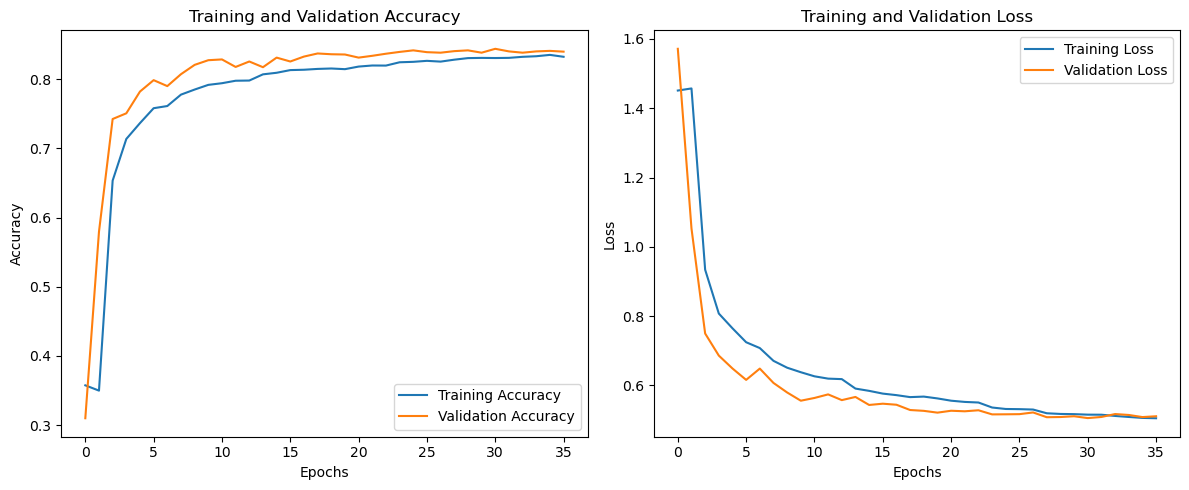

235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step
Classification Report:
               precision    recall  f1-score   support

        bike      0.925     0.858     0.890      1022
         bus      0.842     0.759     0.799      1818
         car      0.673     0.700     0.686      1026
       train      0.962     0.902     0.931      1838
        walk      0.839     0.992     0.909      1800

    accuracy                          0.855      7504
   macro avg      0.848     0.842     0.843      7504
weighted avg      0.859     0.855     0.855      7504



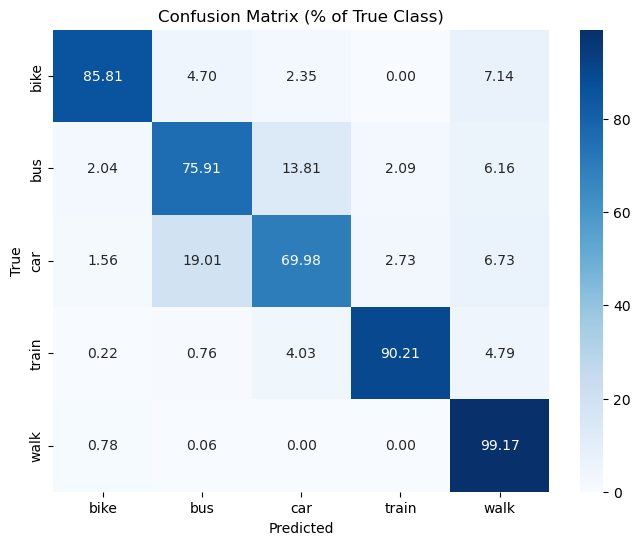

In [60]:
# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# Make predictions
y_pred = model3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report with TRUE LABELS
print("Classification Report:\n", 
      classification_report(
          y_true_classes, 
          y_pred_classes, 
          target_names=label_encoder.classes_,digits=3  # Add class names here
      ))

# Confusion Matrix in percentages
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_percent, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=label_encoder.classes_,  # True labels for axes
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (% of True Class)")
plt.show()

Bi-LSTM

In [61]:
def create_bilstm_model(input_shape, num_classes):
    model = Sequential()
    
    # Conv1D remains the same for initial feature extraction
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    
    # First LSTM converted to Bidirectional
    model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Now processes both directions
    model.add(Dropout(0.3))  # Same dropout rate
    
    # Second LSTM converted to Bidirectional (no return_sequences)
    model.add(Bidirectional(LSTM(64)))  # Now processes both directions
    model.add(Dropout(0.3))
    
    # Dense layers remain unchanged
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compilation remains the same
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [62]:
input_shape = (X_train2.shape[1], X_train2.shape[2])  # (time_steps, features)
num_classes = y_train.shape[1]
model3bi = create_bilstm_model(input_shape, num_classes)

model3bi.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 198, 32)        │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 198, 256)       │       164,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 198, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 340,133 (1.30 MB)

 Trainable params: 340,133 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# Reduce learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model to best state
)

# Train the model
history = model3bi.fit(X_train2, y_train2, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 240s 303ms/step - accuracy: 0.4418 - loss: 1.3294 - val_accuracy: 0.2810 - val_loss: 2.1304 - learning_rate: 0.0010
Epoch 2/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 248s 316ms/step - accuracy: 0.5440 - loss: 1.1254 - val_accuracy: 0.5826 - val_loss: 1.0108 - learning_rate: 0.0010
Epoch 3/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 246s 313ms/step - accuracy: 0.5941 - loss: 1.0439 - val_accuracy: 0.6931 - val_loss: 0.8257 - learning_rate: 0.0010
Epoch 4/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 254s 324ms/step - accuracy: 0.6112 - loss: 0.9923 - val_accuracy: 0.6103 - val_loss: 0.9692 - learning_rate: 0.0010
Epoch 5/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 252s 321ms/step - accuracy: 0.5304 - loss: 1.2014 - val_accuracy: 0.6635 - val_loss: 0.8955 - learning_rate: 0.0010
Epoch 6/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 251s 320ms/step - accuracy: 0.6200 - loss: 0.9732 - val_accuracy: 0.7119 - val_loss: 0.8122 - learning_rate: 0.0010
Epoch 7/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 253s 323ms/step - accura

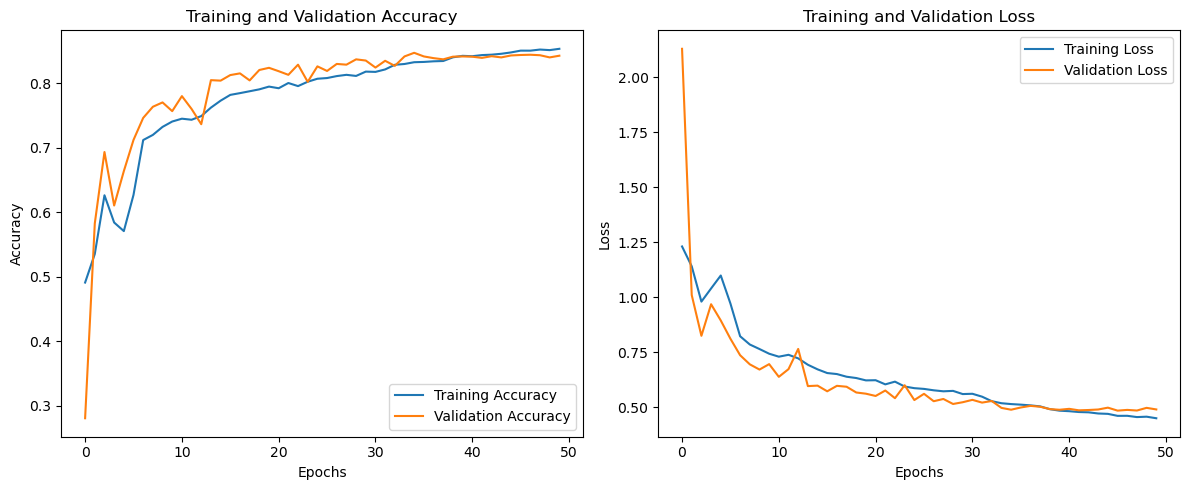

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step
Classification Report:
               precision    recall  f1-score   support

        bike      0.902     0.870     0.885      1022
         bus      0.850     0.733     0.787      1818
         car      0.668     0.729     0.697      1026
       train      0.961     0.906     0.933      1838
        walk      0.848     0.988     0.913      1800

    accuracy                          0.855      7504
   macro avg      0.846     0.845     0.843      7504
weighted avg      0.859     0.855     0.854      7504



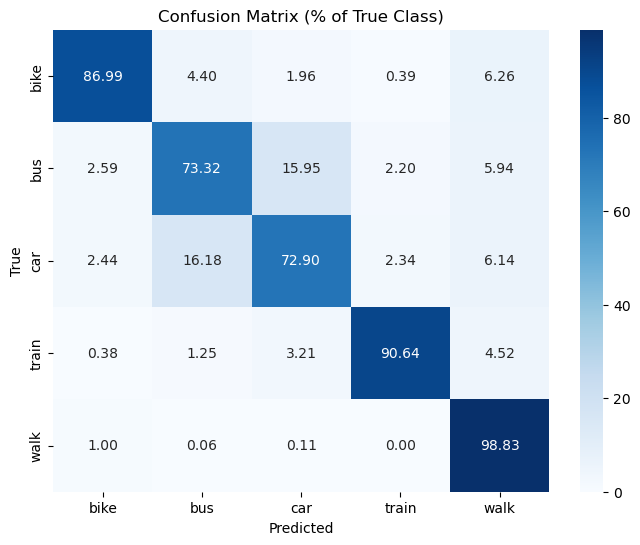

In [64]:
# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# Make predictions
y_pred = model3bi.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report with TRUE LABELS
print("Classification Report:\n", 
      classification_report(
          y_true_classes, 
          y_pred_classes, 
          target_names=label_encoder.classes_ ,digits=3 # Add class names here
      ))

# Confusion Matrix in percentages
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_percent, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=label_encoder.classes_,  # True labels for axes
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (% of True Class)")
plt.show()

Plotting the test set

In [16]:
time_series_features = ['speed', 'acceleration','jerk','heading_change','angular_velocity', 'angular_acceleration']

In [ ]:
segment_column = 'segment' 
test_set_ratio = 0.2       # 20% of segments for testing
random_seed = 19    

In [ ]:
unique_segments = df[segment_column].unique()
n_total_segments = len(unique_segments)
print(f"Total unique segments found: {n_total_segments}")

train_segments, test_segments = train_test_split(
    unique_segments,
    test_size=test_set_ratio,
    random_state=random_seed,
    shuffle=True # Ensure random selection of segments
)

n_train_segments = len(train_segments)
n_test_segments = len(test_segments)
print(f"Splitting into: {n_train_segments} train segments and {n_test_segments} test segments.")
print(f"Actual test segment ratio: {n_test_segments / n_total_segments:.2f}")

Total unique segments found: 13901
Splitting into: 11120 train segments and 2781 test segments.
Actual test segment ratio: 0.20


In [ ]:
train_df = df[df[segment_column].isin(train_segments)].copy()
test_df = df[df[segment_column].isin(test_segments)].copy()

print(f"\nOriginal DataFrame shape: {df.shape}")
print(f"Training DataFrame shape: {train_df.shape}")
print(f"Testing DataFrame shape:  {test_df.shape}")

train_segments_in_df = set(train_df[segment_column].unique())
test_segments_in_df = set(test_df[segment_column].unique())
common_segments = train_segments_in_df.intersection(test_segments_in_df)



Original DataFrame shape: (4120885, 19)
Training DataFrame shape: (3242823, 19)
Testing DataFrame shape:  (878062, 19)


Cap test sequences at 200 in the dateframe

In [ ]:
segment_column_name = 'segment' 
new_segment_column_name = 'new_segment'  
window_size = 200 # The "cap" or max size for chunks from long segments
step_size = 200   # Step size for rolling window on long segments

# List to hold the processed DataFrames (chunks/original short segments)
processed_chunks_list = []

# Group by the original segment ID
grouped = test_df.groupby(segment_column_name, sort=False) # sort=False preserves original order

print(f"Processing {len(grouped)} original segments...")

for segment_id, group in grouped:
    n = len(group)
    group = group.copy()

    if n <= window_size:
        # No padding applied. The segment length remains 'n'.
        new_id = f"{segment_id}_0"
        group[new_segment_column_name] = new_id
        processed_chunks_list.append(group)

    else: # n > window_size
        # Segment is longer (> 200): Create overlapping 200-point chunks
        num_chunks_generated = 0
        # The last possible start index is n - window_size
        for i, start in enumerate(range(0, n - window_size + 1, step_size)):
            end = start + window_size
            chunk = group.iloc[start:end].copy() # Extract the 200-point chunk
            new_id = f"{segment_id}_{i}"
            chunk[new_segment_column_name] = new_id
            processed_chunks_list.append(chunk)
            num_chunks_generated += 1


# Concatenate all processed chunks into a single DataFrame
if processed_chunks_list:
    final_test_df = pd.concat(processed_chunks_list, ignore_index=True)
    print(f"\nFinished processing. Original rows: {len(test_df)}, New DataFrame rows: {len(final_test_df)}")
    print(f"Number of unique new segments created: {final_test_df[new_segment_column_name].nunique()}")

    # Display sample
    print("\nSample of the final DataFrame with new segments:")
    print(final_test_df.head())
    print("...")
    print(final_test_df.tail())

    print("\nCounts per new segment (sample - lengths can be <= 200):")
    segment_counts = final_test_df[new_segment_column_name].value_counts()
    print(segment_counts.head(10))
    print(f"Range of segment lengths: {segment_counts.min()} to {segment_counts.max()}")


else:
    print("\nNo chunks were generated (the input DataFrame might be empty).")
    final_test_df = pd.DataFrame()

Processing 2781 original segments...

Finished processing. Original rows: 878062, New DataFrame rows: 769952
Number of unique new segments created: 4892

Sample of the final DataFrame with new segments:
         lat         lon         alt  elapsed time                time  \
0  39.968333  116.345350  180.446194  39185.037859 2007-04-13 00:54:31   
1  39.968700  116.345733  187.007874  39185.038079 2007-04-13 00:54:50   
2  39.969167  116.345783  150.918635  39185.038264 2007-04-13 00:55:06   
3  39.969633  116.345750  154.199475  39185.038426 2007-04-13 00:55:20   
4  39.970100  116.345733  150.918635  39185.038588 2007-04-13 00:55:34   

           trajectory  label  user  segment  distance     speed  time_diff  \
0  20070413005306.plt      0   163        9  0.050038  0.036126       17.0   
1  20070413005306.plt      0   163        9  0.052244  0.033749       19.0   
2  20070413005306.plt      0   163        9  0.052066  0.039940       16.0   
3  20070413005306.plt      0   163      

In [78]:
final_test_df

lat         lon         alt  elapsed time                time  \
0       39.968333  116.345350  180.446194  39185.037859 2007-04-13 00:54:31   
1       39.968700  116.345733  187.007874  39185.038079 2007-04-13 00:54:50   
2       39.969167  116.345783  150.918635  39185.038264 2007-04-13 00:55:06   
3       39.969633  116.345750  154.199475  39185.038426 2007-04-13 00:55:20   
4       39.970100  116.345733  150.918635  39185.038588 2007-04-13 00:55:34   
...           ...         ...         ...           ...                 ...   
769947  39.978662  116.304592    0.000000  40908.342998 2011-12-31 08:13:55   
769948  39.952757  116.444345    0.000000  40908.622014 2011-12-31 14:55:42   
769949  39.952757  116.444350    0.000000  40908.622072 2011-12-31 14:55:47   
769950  39.952752  116.444313    0.000000  40908.622130 2011-12-31 14:55:52   
769951  39.952775  116.444410    0.000000  40908.622187 2011-12-31 14:55:57   

                trajectory  label  user  segment  distance     speed  \
0       20070413005306.plt      0   163        9  0.050038  0.036126   
1       20070413005306.plt      0   163        9  0.052244  0.033749   
2       20070413005306.plt      0   163        9  0.052066  0.039940   
3       20070413005306.plt      0   163        9  0.051969  0.045560   
4       20070413005306.plt      0   163        9  0.051910  0.045509   
...                    ...    ...   ...      ...       ...       ...   
769947  20111231075505.plt      4   102    25129  0.002484  0.006098   
769948  20111231144437.plt      4   102    25131  0.003648  0.008954   
769949  20111231144437.plt      4   102    25131  0.000426  0.002615   
769950  20111231144437.plt      4   102    25131  0.003175  0.007792   
769951  20111231144437.plt      4   102    25131  0.008639  0.021205   

        time_diff  acceleration      jerk     bearing  heading_change  \
0            17.0      0.883785  0.003703    0.000000        0.034712   
1            19.0      0.883822  0.003703   38.702763        0.215015   
2            16.0      0.883892  0.003703    4.694211        0.188936   
3            14.0      0.883894  0.003703  356.866654        0.043486   
4            14.0      0.883838  0.003703  358.432165        0.008697   
...           ...           ...       ...         ...             ...   
769947        5.0      0.883818  0.003703   34.861902        0.024137   
769948        5.0      0.883868  0.003703  110.830841        0.846244   
769949        2.0      0.884019  0.003704   89.999998        0.500000   
769950        5.0      0.883982  0.003703  259.913344        0.943963   
769951        5.0      0.884209  0.003703   72.521766        0.958936   

           Vrate  angular_velocity  angular_acceleration new_segment  
0       0.182332          0.002042              0.499868         9_0  
1       0.070440          0.011317              0.500244         9_0  
2       0.155003          0.011809              0.500015         9_0  
3       0.123368          0.003106              0.499689         9_0  
4       0.001122          0.000621              0.499911         9_0  
...          ...               ...                   ...         ...  
769947  0.125648          0.004827              0.493307     25129_0  
769948  0.118308          0.169249              0.511239     25131_0  
769949  1.000000          0.250000              0.511189     25131_0  
769950  0.664360          0.188793              0.493879     25131_0  
769951  0.632522          0.191787              0.500299     25131_0  

[769952 rows x 20 columns]

In [114]:
X_sequences_train = []
y_sequences_train = []

for _, group in train_df.groupby('segment'):
    X_sequences_train.append(group[time_series_features].values)  # Raw sequences
    y_sequences_train.append(group['label'].iloc[0])  # Assign one label per segment

In [ ]:
unique_test_segments_in_order = final_test_df['new_segment'].unique()

X_sequences_test = []
y_sequences_test = []
segment_order_tracker = [] 

for segment_id in unique_test_segments_in_order:
    group = final_test_df[final_test_df['new_segment'] == segment_id]
    if not group.empty:
        X_sequences_test.append(group[time_series_features].values)
        y_sequences_test.append(group['label'].iloc[0])
        segment_order_tracker.append(segment_id) # Store the order we used

print(f"Generated {len(X_sequences_test)} test sequences.")


Generated 4892 test sequences.


In [116]:
# Convert labels to one-hot encoding
y_sequences_train = to_categorical(y_sequences_train)
y_sequences_test = to_categorical(y_sequences_test)

In [117]:
X_train, X_val, y_train, y_val = train_test_split(X_sequences_train, y_sequences_train, test_size=0.1, random_state=19)

In [118]:
X_sequences_test

[array([[3.61261173e-02, 8.83785390e-01, 3.70278340e-03, 3.47123333e-02,
         2.04190196e-03, 4.99868282e-01],
        [3.37487921e-02, 8.83821587e-01, 3.70284302e-03, 2.15015351e-01,
         1.13165974e-02, 5.00244071e-01],
        [3.99396806e-02, 8.83892237e-01, 3.70284996e-03, 1.88936403e-01,
         1.18085252e-02, 5.00015373e-01],
        [4.55604561e-02, 8.83894245e-01, 3.70283815e-03, 4.34864247e-02,
         3.10617319e-03, 4.99689202e-01],
        [4.55093806e-02, 8.83838348e-01, 3.70282671e-03, 8.69728533e-03,
         6.21234666e-04, 4.99911252e-01],
        [4.71335465e-02, 8.83854857e-01, 3.70284101e-03, 1.71201152e-02,
         1.22286537e-03, 5.00021487e-01],
        [3.44793785e-02, 8.83741855e-01, 3.70282039e-03, 4.49747087e-01,
         2.49859493e-02, 5.00660086e-01],
        [2.22432467e-02, 8.83776323e-01, 3.70284128e-03, 3.85618844e-01,
         1.42821794e-02, 4.99801782e-01],
        [4.94912322e-02, 8.84128042e-01, 3.70291257e-03, 1.52048966e-01,
       

In [119]:
# Create rolling windows
X_train, y_train = create_rolling_windows(X_train, y_train)

# Verify shape
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (24939, 200, 6)
Shape of y_train: (24939, 5)


In [120]:
# Create rolling windows
X_val, y_val = create_rolling_windows(X_val, y_val)

# Verify shape
print("Shape of X_val", X_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_val (2824, 200, 6)
Shape of y_val: (2824, 5)


In [121]:
# Create rolling windows
X_test, y_test = create_rolling_windows(X_sequences_test, y_sequences_test, 200,200)

# Verify shape
print("Shape of X_val", X_test.shape)
print("Shape of y_val:", y_test.shape)

Shape of X_val (4892, 200, 6)
Shape of y_val: (4892, 5)


In [122]:
def create_lstm_model(input_shape, num_classes):
    model = Sequential()
    
    # Use Conv1D for time-series feature extraction
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    
    # LSTM Layers
    model.add(LSTM(128, return_sequences=True))  # Retain temporal dimension
    model.add(Dropout(0.3))
    
    model.add(LSTM(64))  # Final LSTM layer returns output (no sequence)
    model.add(Dropout(0.3))
    
    # Dense Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [72]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, features)
num_classes = y_train.shape[1]
model = create_lstm_model(input_shape, num_classes)

model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 198, 32)        │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 198, 128)       │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 198, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,853 (542.39 KB)

 Trainable params: 138,853 (542.39 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
# Reduce learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model to best state
)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 112s 141ms/step - accuracy: 0.3445 - loss: 1.5130 - val_accuracy: 0.6243 - val_loss: 0.9727 - learning_rate: 0.0010
Epoch 2/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 113s 145ms/step - accuracy: 0.6560 - loss: 0.9548 - val_accuracy: 0.7146 - val_loss: 0.7656 - learning_rate: 0.0010
Epoch 3/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 116s 149ms/step - accuracy: 0.7232 - loss: 0.7991 - val_accuracy: 0.7415 - val_loss: 0.7206 - learning_rate: 0.0010
Epoch 4/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 110s 141ms/step - accuracy: 0.7333 - loss: 0.7665 - val_accuracy: 0.7518 - val_loss: 0.7113 - learning_rate: 0.0010
Epoch 5/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 113s 145ms/step - accuracy: 0.7594 - loss: 0.7251 - val_accuracy: 0.7712 - val_loss: 0.6672 - learning_rate: 0.0010
Epoch 6/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 110s 141ms/step - accuracy: 0.7550 - loss: 0.7211 - val_accuracy: 0.7535 - val_loss: 0.6874 - learning_rate: 0.0010
Epoch 7/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 110s 141ms/step - accura

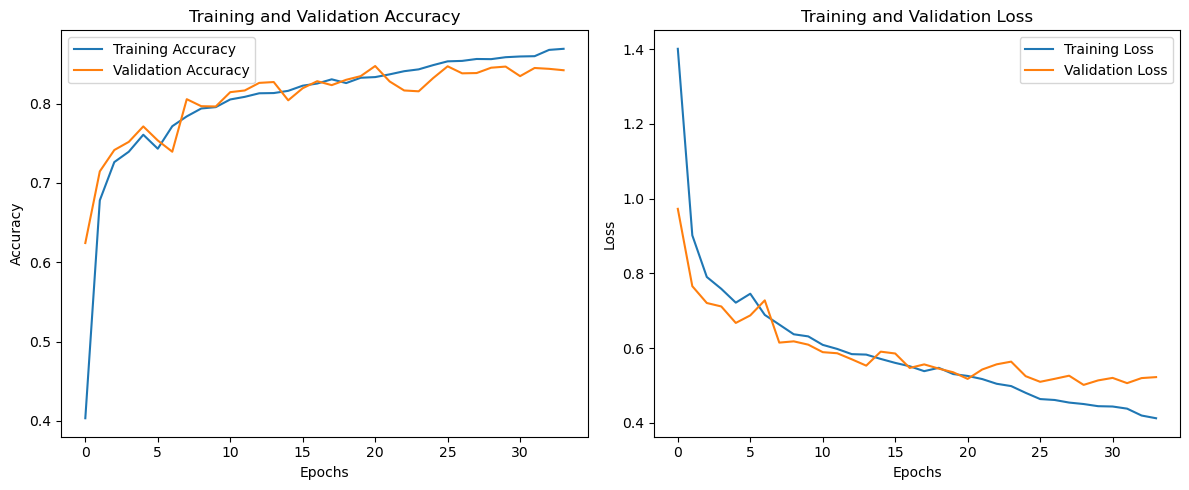

153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step
Classification Report:
               precision    recall  f1-score   support

        bike      0.914     0.849     0.880       654
         bus      0.863     0.716     0.783      1121
         car      0.694     0.751     0.721       678
       train      0.952     0.897     0.923      1016
        walk      0.843     0.986     0.909      1423

    accuracy                          0.855      4892
   macro avg      0.853     0.840     0.843      4892
weighted avg      0.859     0.855     0.853      4892



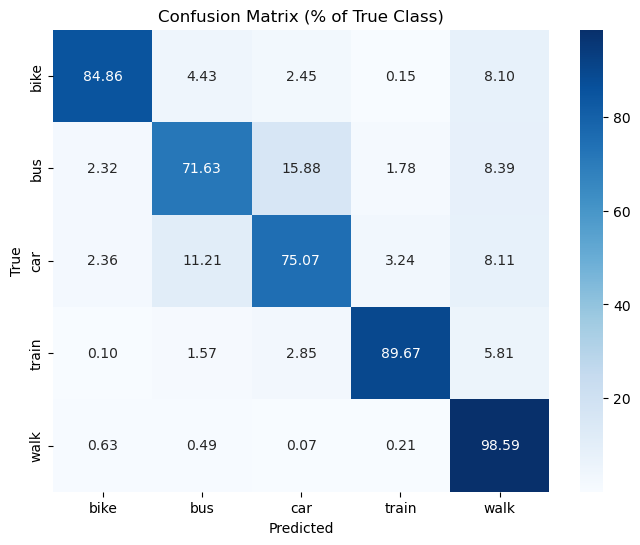

In [84]:
# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report with TRUE LABELS
print("Classification Report:\n", 
      classification_report(
          y_true_classes, 
          y_pred_classes, 
          target_names=label_encoder.classes_ ,digits=3 # Add class names here
      ))

# Confusion Matrix in percentages
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_percent, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=label_encoder.classes_,  # True labels for axes
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (% of True Class)")
plt.show()

In [123]:
y_pred_probs = model.predict(X_test)

153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step


In [124]:
y_pred_classes = np.argmax(y_pred_probs, axis=1)

In [ ]:
new_segment_col = 'new_segment' 
if new_segment_col not in final_test_df.columns:
    raise ValueError(f"Column '{new_segment_col}' not found in test_df.")

print(f"DataFrame shape: {final_test_df.shape}")
print(f"Number of predictions provided: {len(y_pred_classes)}")

unique_segments = final_test_df[new_segment_col].unique()
num_unique_segments = len(unique_segments)
print(f"Number of unique segments found in DataFrame: {num_unique_segments}")

if num_unique_segments != len(y_pred_classes):
    raise ValueError(f"Mismatch! Found {num_unique_segments} unique segments but received {len(y_pred_classes)} predictions.")
else:
    print("Number of unique segments matches number of predictions.")


print("Creating segment-to-prediction map...")
segment_to_prediction_map = dict(zip(unique_segments, y_pred_classes))

print(f"Mapping predictions to new column 'predicted_class'...")
final_test_df['predicted_class'] = final_test_df[new_segment_col].map(segment_to_prediction_map)

print("Mapping complete.")
print("\nSample of test_df with mapped predictions:")

display_cols = [new_segment_col, 'predicted_class']


other_cols = [col for col in final_test_df.columns if col not in display_cols]
if len(other_cols) > 2:
     display_cols = other_cols[:2] + display_cols
elif other_cols:
     display_cols = other_cols + display_cols

print(final_test_df[display_cols].head(10))
print("...")

if len(final_test_df) > 500:
  print(final_test_df[display_cols].iloc[495:505])


segment_check = final_test_df.groupby(new_segment_col)['predicted_class'].nunique()
if (segment_check == 1).all():
    print("\nVerification successful: All rows within each segment have the same mapped prediction.")
else:
    print("\nVerification Warning: Some segments have multiple different predictions mapped!")
    print(segment_check[segment_check > 1])

nan_count = final_test_df['predicted_class'].isna().sum()
if nan_count == 0:
    print("Verification successful: No missing predictions after mapping.")
else:
    print(f"\nVerification Warning: {nan_count} rows have missing predictions after mapping!")

DataFrame shape: (769952, 20)
Number of predictions provided: 4892
Number of unique segments found in DataFrame: 4892
Number of unique segments matches number of predictions.
Creating segment-to-prediction map...
Mapping predictions to new column 'predicted_class'...
Mapping complete.

Sample of test_df with mapped predictions:
         lat         lon new_segment  predicted_class
0  39.968333  116.345350         9_0                0
1  39.968700  116.345733         9_0                0
2  39.969167  116.345783         9_0                0
3  39.969633  116.345750         9_0                0
4  39.970100  116.345733         9_0                0
5  39.970583  116.345750         9_0                0
6  39.970667  116.345167         9_0                0
7  39.971100  116.345067         9_0                0
8  39.971550  116.345250         9_0                0
9  39.972000  116.345150         9_0                0
...
           lat         lon new_segment  predicted_class
495  39.990450  

In [99]:
final_test_df

lat         lon         alt  elapsed time                time  \
0       39.968333  116.345350  180.446194  39185.037859 2007-04-13 00:54:31   
1       39.968700  116.345733  187.007874  39185.038079 2007-04-13 00:54:50   
2       39.969167  116.345783  150.918635  39185.038264 2007-04-13 00:55:06   
3       39.969633  116.345750  154.199475  39185.038426 2007-04-13 00:55:20   
4       39.970100  116.345733  150.918635  39185.038588 2007-04-13 00:55:34   
...           ...         ...         ...           ...                 ...   
769947  39.978662  116.304592    0.000000  40908.342998 2011-12-31 08:13:55   
769948  39.952757  116.444345    0.000000  40908.622014 2011-12-31 14:55:42   
769949  39.952757  116.444350    0.000000  40908.622072 2011-12-31 14:55:47   
769950  39.952752  116.444313    0.000000  40908.622130 2011-12-31 14:55:52   
769951  39.952775  116.444410    0.000000  40908.622187 2011-12-31 14:55:57   

                trajectory  label  user  segment  distance  ...  time_diff  \
0       20070413005306.plt      0   163        9  0.050038  ...       17.0   
1       20070413005306.plt      0   163        9  0.052244  ...       19.0   
2       20070413005306.plt      0   163        9  0.052066  ...       16.0   
3       20070413005306.plt      0   163        9  0.051969  ...       14.0   
4       20070413005306.plt      0   163        9  0.051910  ...       14.0   
...                    ...    ...   ...      ...       ...  ...        ...   
769947  20111231075505.plt      4   102    25129  0.002484  ...        5.0   
769948  20111231144437.plt      4   102    25131  0.003648  ...        5.0   
769949  20111231144437.plt      4   102    25131  0.000426  ...        2.0   
769950  20111231144437.plt      4   102    25131  0.003175  ...        5.0   
769951  20111231144437.plt      4   102    25131  0.008639  ...        5.0   

        acceleration      jerk     bearing  heading_change     Vrate  \
0           0.883785  0.003703    0.000000        0.034712  0.182332   
1           0.883822  0.003703   38.702763        0.215015  0.070440   
2           0.883892  0.003703    4.694211        0.188936  0.155003   
3           0.883894  0.003703  356.866654        0.043486  0.123368   
4           0.883838  0.003703  358.432165        0.008697  0.001122   
...              ...       ...         ...             ...       ...   
769947      0.883818  0.003703   34.861902        0.024137  0.125648   
769948      0.883868  0.003703  110.830841        0.846244  0.118308   
769949      0.884019  0.003704   89.999998        0.500000  1.000000   
769950      0.883982  0.003703  259.913344        0.943963  0.664360   
769951      0.884209  0.003703   72.521766        0.958936  0.632522   

        angular_velocity  angular_acceleration  new_segment predicted_class  
0               0.002042              0.499868          9_0               4  
1               0.011317              0.500244          9_0               4  
2               0.011809              0.500015          9_0               4  
3               0.003106              0.499689          9_0               4  
4               0.000621              0.499911          9_0               4  
...                  ...                   ...          ...             ...  
769947          0.004827              0.493307      25129_0               2  
769948          0.169249              0.511239      25131_0               0  
769949          0.250000              0.511189      25131_0               0  
769950          0.188793              0.493879      25131_0               0  
769951          0.191787              0.500299      25131_0               0  

[769952 rows x 21 columns]

Decode the labels (pseudo-label and original label)

In [126]:
final_test_df['label'] = label_encoder.inverse_transform(final_test_df['label'])
final_test_df['predicted_class'] = label_encoder.inverse_transform(final_test_df['predicted_class'])

Plot the real labels

In [127]:
segment = final_test_df.groupby('new_segment')

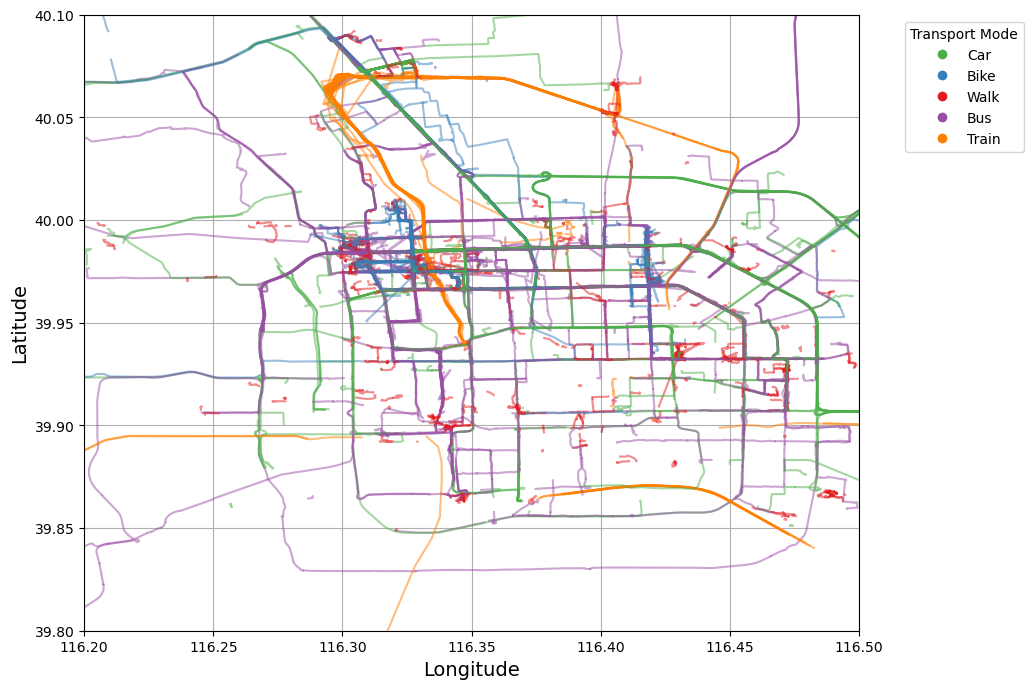

In [ ]:
color_palette = sns.color_palette("Set1", 8)

color_map = {
    'walk': color_palette[0],   # Soft Green
    'bike': color_palette[1],   # Light Orange
    'car': color_palette[2],    # Light Blue
    'bus': color_palette[3],    # Light Purple
    'train': color_palette[4],  # Teal
    '0': color_palette[5]         # Default for missing labels
}
plt.figure(figsize=(10, 8))
#plt.title("Geolife Trajectories by Transport Mode", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

plt.xlim(116.2, 116.5)  # Longitude limits
plt.ylim(39.8, 40.1)  # Latitude limits

# Track unique transport modes for legend
unique_labels = set()

# Iterate over each segment and plot it with the corresponding color
for name, group in segment:
    transport_mode = group['label'].iloc[0]  # Take the first label for the segment
    color = color_map.get(transport_mode, 'black')  # Default to black if label is unknown
    plt.plot(group['lon'], group['lat'],color=color, alpha=0.5)
    unique_labels.add(transport_mode)  # Collect unique transport modes for legend

# Create a custom legend with label replacements
handles = []
labels = []
for label in unique_labels:
    # Replace '0' with "Unlabeled" in legend
    display_label = "Unlabeled" if str(label) == '0' else str(label).capitalize()
    handles.append(plt.Line2D([0], [0], 
                    color=color_map.get(str(label), 'gray'), 
                    lw=2,
                    marker='o',
                    linestyle='None'))
    labels.append(display_label)

plt.legend(handles, labels, 
           title="Transport Mode", 
           bbox_to_anchor=(1.05, 1), 
           loc='upper left',
           fontsize=10)

#plt.tight_layout()
plt.grid()

# Save the plot
plt.savefig("Graphs/testset_truelabels", dpi=500, bbox_inches="tight")
#plt.savefig(save_path, dpi=600, format="png", bbox_inches="tight", transparent=True)
plt.show()

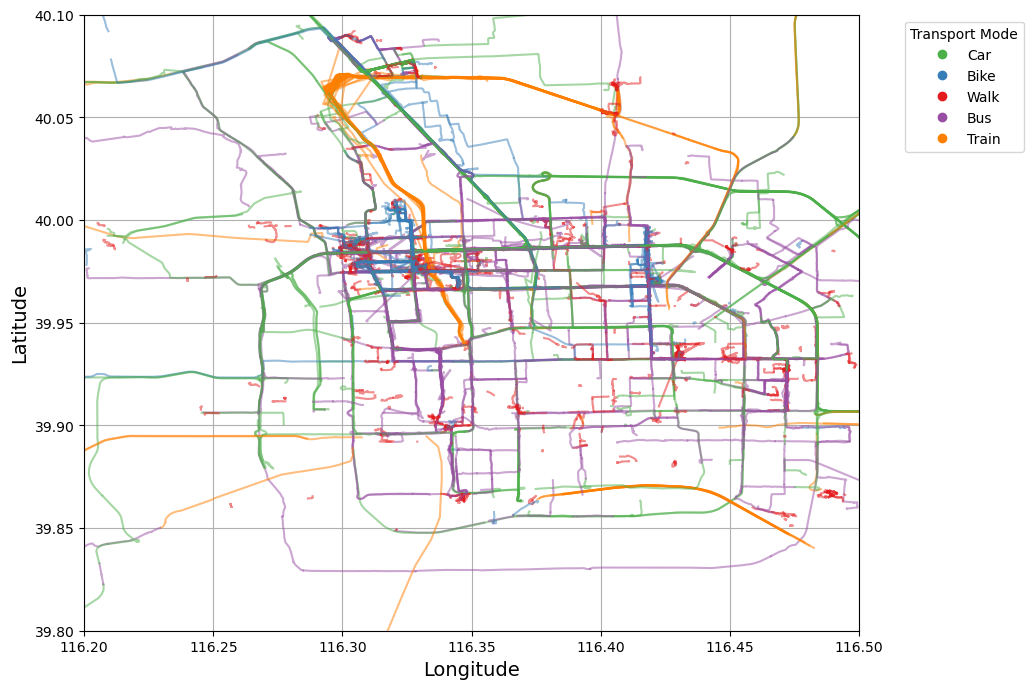

In [ ]:
color_palette = sns.color_palette("Set1", 8)

# Assign transport modes to colors
color_map = {
    'walk': color_palette[0],   # Soft Green
    'bike': color_palette[1],   # Light Orange
    'car': color_palette[2],    # Light Blue
    'bus': color_palette[3],    # Light Purple
    'train': color_palette[4],  # Teal
    '0': color_palette[5]         # Default for missing labels
}
plt.figure(figsize=(10, 8))
#plt.title("Geolife Trajectories by Transport Mode", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

plt.xlim(116.2, 116.5)  # Longitude limits
plt.ylim(39.8, 40.1)  # Latitude limits

# Track unique transport modes for legend
unique_labels = set()

# Iterate over each segment and plot it with the corresponding color
for name, group in segment:
    transport_mode = group['predicted_class'].iloc[0]  # Take the first label for the segment
    color = color_map.get(transport_mode, 'black')  # Default to black if label is unknown
    plt.plot(group['lon'], group['lat'],color=color, alpha=0.5)
    unique_labels.add(transport_mode)  # Collect unique transport modes for legend

# Create a custom legend with label replacements
handles = []
labels = []
for label in unique_labels:
    # Replace '0' with "Unlabeled" in legend
    display_label = "Unlabeled" if str(label) == '0' else str(label).capitalize()
    handles.append(plt.Line2D([0], [0], 
                    color=color_map.get(str(label), 'gray'), 
                    lw=2,
                    marker='o',
                    linestyle='None'))
    labels.append(display_label)

plt.legend(handles, labels, 
           title="Transport Mode", 
           bbox_to_anchor=(1.05, 1), 
           loc='upper left',
           fontsize=10)

#plt.tight_layout()
plt.grid()

# Save the plot
plt.savefig("Graphs/testset_predictedlabels", dpi=500, bbox_inches="tight")
#plt.savefig(save_path, dpi=600, format="png", bbox_inches="tight", transparent=True)
plt.show()

Plot single predicted segments

In [ ]:
new_df = df[df['segment']==16817]
new_df = new_df[3:]

In [16]:
model = tf.keras.models.load_model('convlstm6filtered.keras')

In [17]:
time_series_features = ['speed', 'acceleration','jerk','heading_change','angular_velocity', 'angular_acceleration']

In [ ]:
selected_columns_df = new_df[time_series_features]

features_array = selected_columns_df.to_numpy()

In [ ]:

print(features_array.shape)


(200, 6)
Number of rows: 200
Number of columns: 6


In [ ]:
# Reshape the array
reshaped_array_reshape = features_array.reshape(1, 200, 6)

In [29]:
single= model.predict(reshaped_array_reshape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


In [30]:
single

array([[2.4763694e-02, 5.5195469e-01, 4.2179632e-01, 1.4785278e-03,
        6.8634204e-06]], dtype=float32)

In [33]:
y_pred_classes = np.argmax(single, axis=1)

In [34]:
y_pred_classes

array([1])

Plot

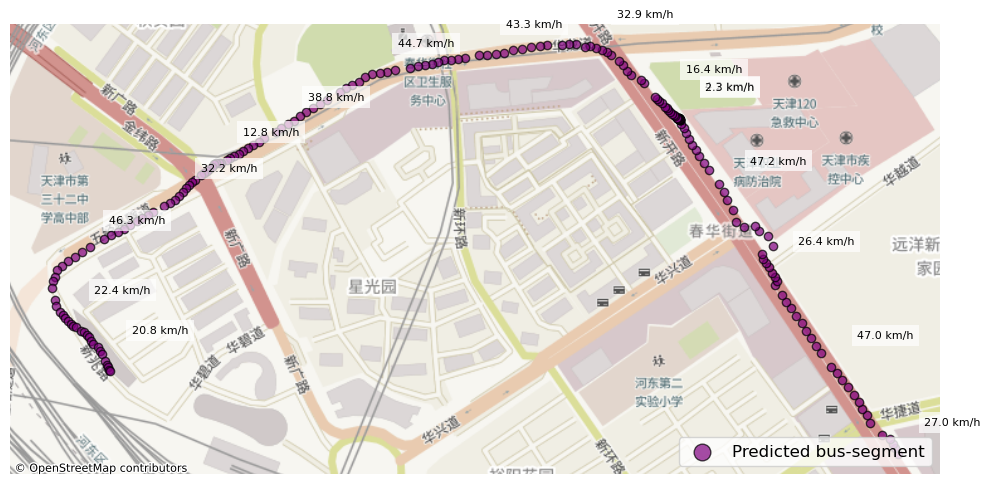

In [ ]:
# Get the Set1 color palette
color_palette = sns.color_palette("Set1", 8)

# Convert coordinates
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3857', always_xy=True)
new_df['x'], new_df['y'] = transformer.transform(
    new_df['lon'].values, 
    new_df['lat'].values
)

# Create plot
fig, ax = plt.subplots(figsize=(12, 8))

# Assign colors and labels
colors = {16817: 'purple'}
labels = {16817: 'Predicted bus-segment'}

for segment, group in new_df.groupby('segment'):  
    ax.scatter(
        group['x'], 
        group['y'], 
        color=colors[segment], 
        label=labels[segment],
        alpha=0.7, 
        edgecolor='k',
        zorder=2  # Ensure points appear above basemap
    )

x_offset = 50  
y_offset = 50 
for i in range(0, len(new_df), 13):
    row = new_df.iloc[i]
    label_x = row['x'] + x_offset
    label_y = row['y'] + y_offset

    ax.text(
        label_x,  # Use the offset x-coordinate
        label_y,  # Use the offset y-coordinate
        f"{row['speed']:.1f} km/h",
        fontsize=8,

        ha='left',
        # 'bottom', 'center', 'top', 'baseline'
        va='bottom',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'),
        zorder=3 # Ensure labels are above points if needed
    )

# Add basemap
ctx.add_basemap(
    ax,
    url="https://tile.openstreetmap.org/{z}/{x}/{y}.png",
    attribution="© OpenStreetMap contributors",
    zorder=1  # Place basemap below points
)

# Customize plot bounds
x_min, x_max = new_df['x'].min(), new_df['x'].max()
y_min, y_max = new_df['y'].min(), new_df['y'].max()

x_pad = (x_max - x_min) * 0.1
y_pad = (y_max - y_min) * 20

#ax.set_xlim(x_min - x_pad, x_max + x_pad)
#ax.set_ylim(y_min - y_pad, y_max + y_pad)

# Final adjustments
ax.set_aspect('equal')
ax.set_axis_off()

plt.legend(
    #title='Trajectory segments',
    loc='lower right',
    fontsize=12,
    title_fontsize=14,
    markerscale=2,
    frameon=True,
    framealpha=0.8
)

plt.savefig("Graphs/Conv_LSTM_single_preicted", dpi=500, bbox_inches="tight")
plt.show()